In [1]:
import pandas as pd
import geopandas as gpd
%matplotlib notebook
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
from scipy import stats
import scipy
import seaborn as sns
import numpy as np
import urllib.request as urllib2

from bokeh.io import output_file, output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
output_notebook()

from bokeh.io import show
from bokeh.io import curdoc
from bokeh.models import (CDSView, ColorBar, ColumnDataSource, CustomJS,
                          CustomJSFilter, GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider, Select)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure, output_file
import bokeh
from bokeh.models import Legend, LegendItem
from bokeh.models import Label
from bokeh.models.tickers import DatetimeTicker
from bokeh.sampledata.sample_geojson import geojson

Loading BokehJS ...

In [2]:
def get_covid(day):
    
    """Day format
    "03-24-2020"
    
    """
    
    baseweb = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'

    ##############Change the day!!

    d = day

    csv = ".csv"

    jhweb = baseweb + day + csv


    jhtime = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

    jh3 = pd.read_csv(jhweb)

    jht = pd.read_csv(jhtime)
    
    us = jh3.loc[jh3.Country_Region == "US"]
    us_geometry = [Point(xy) for xy in zip(us.Long_, us.Lat)]
    us_gdf = gpd.GeoDataFrame(us, geometry = us_geometry)
    
    nots = ['Diamond Princess', 'Grand Princess', 'Guam',
       'Northern Mariana Islands', 'Puerto Rico', 'Recovered',
       'Virgin Islands', 'Alaska', 'Hawaii', 'American Samoa', 'Wuhan Evacuee']

    us_gdf = us_gdf.loc[(~us_gdf.Province_State.isin(nots))]
    us_gdf = us_gdf.dropna(subset=['FIPS'], axis=0)
    
    return jh3, jht, us_gdf

jh3, jht, us_gdf = get_covid("03-24-2020")


In [3]:

def shape():
    
    counties = gpd.read_file('usa/UScounties.shp')
    counties.FIPS =counties.FIPS.astype(int) 
    
    return counties

counties = shape()

In [4]:
def get_sahi():
    
    sahi = pd.read_csv('sahie_2017.csv')
    sahi_c = sahi.loc[sahi.geocat == 50]
    sahi_all = sahi_c.loc[(sahi_c.iprcat == 0) & (sahi_c.racecat == 0) &(sahi_c.sexcat == 0) &
                      (sahi_c.agecat == 0)]

    return sahi_all
sahi = get_sahi()

C:\Users\Jesus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
def merge_all(sahi, counties, jh3):
    
    us_counties = counties.merge(sahi, left_on='FIPS', right_on='cfips', how='left')
    
    us_counties = us_counties.dropna(subset=['PCTUI', 'geometry'], axis=0)
    us_counties = us_counties.loc[us_counties.PCTUI != "   . "] 
    us_all = us_counties.merge(jh3, on='FIPS', how='left')
    
    to_float = [ 'NIPR', 'nipr_moe', 'NUI',
       'nui_moe', 'NIC', 'nic_moe', 'PCTUI', 'pctui_moe', 'PCTIC', 'pctic_moe',
       'PCTELIG', 'pctelig_moe', 'PCTLIIC', 'pctliic_moe']
    us_all[to_float] = us_all[to_float].astype(float)
    
    us_all = us_all.loc[(us_all.STATE_NAME != "Alaska") & (us_all.STATE_NAME != "Hawaii")]

    
    return us_all

us_all = merge_all(sahi, counties, jh3)



In [6]:
def geosm(us_all, us_gdf):
    
    us_all1 = us_all.dropna(subset=['FIPS'], axis=0)
    us_gdf1 = us_gdf.dropna(subset=['FIPS'], axis=0)
    x = us_all1.to_json()
    y = us_gdf1.to_json()
    
    geosource = GeoJSONDataSource(geojson = x)
    corona = GeoJSONDataSource(geojson = y)
    
    return geosource, corona

geosource, corona = geosm(us_all, us_gdf)

In [7]:
def state_group(us_all):
    state = us_all.groupby('STATE_NAME')['NIPR','NUI','Confirmed','Deaths'].sum().reset_index()
    state['pct_unin'] = state['NUI']/state['NIPR']
    return state

state = state_group(us_all)

def nation_group(jht):
    nat = jht
    #nat = jht.loc[jht['Country/Region'] == "US"]
    gr = nat.groupby('Country/Region').sum().reset_index()
    gr.drop(columns=['Lat', 'Long'], inplace=True)
    
    timseries = pd.melt(gr, id_vars=['Country/Region'])
    
    
    return timseries

covid = nation_group(jht)

In [108]:
us_all.PCTIC.describe()

count    3109.000000
mean       88.582985
std         5.104224
min        66.300000
25%        85.600000
50%        89.500000
75%        92.600000
max        97.700000
Name: PCTIC, dtype: float64

In [47]:
xs = pd.to_datetime(covid['variable'])
ys = covid['value']

<IPython.core.display.Javascript object>


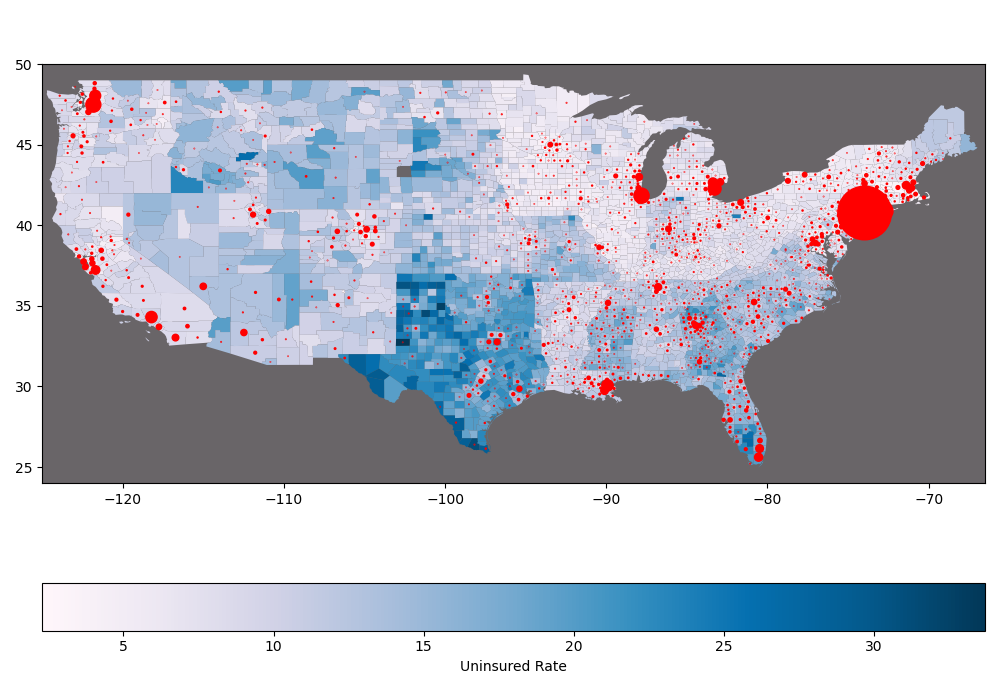

In [8]:
fig, ax = plt.subplots(figsize=(10,7))

us_all.plot(column='PCTUI',cmap='PuBu',ax=ax, legend=True, legend_kwds={'label':"Uninsured Rate",
                       'orientation':"horizontal"})
us_gdf.plot(ax=ax, color='red', markersize=.1*us_gdf['Confirmed'])
ax.set_facecolor('#696568')
ax.set_xlim(-125, -66.5)
ax.set_ylim(24,50)
fig.tight_layout()

In [9]:
bins = [2, 7.41, 10.61, 14.50,34]
labels = [1,2,3,4]

us_all['pct_bin'] = pd.cut(us_all['PCTUI'], bins,labels=labels)

<IPython.core.display.Javascript object>


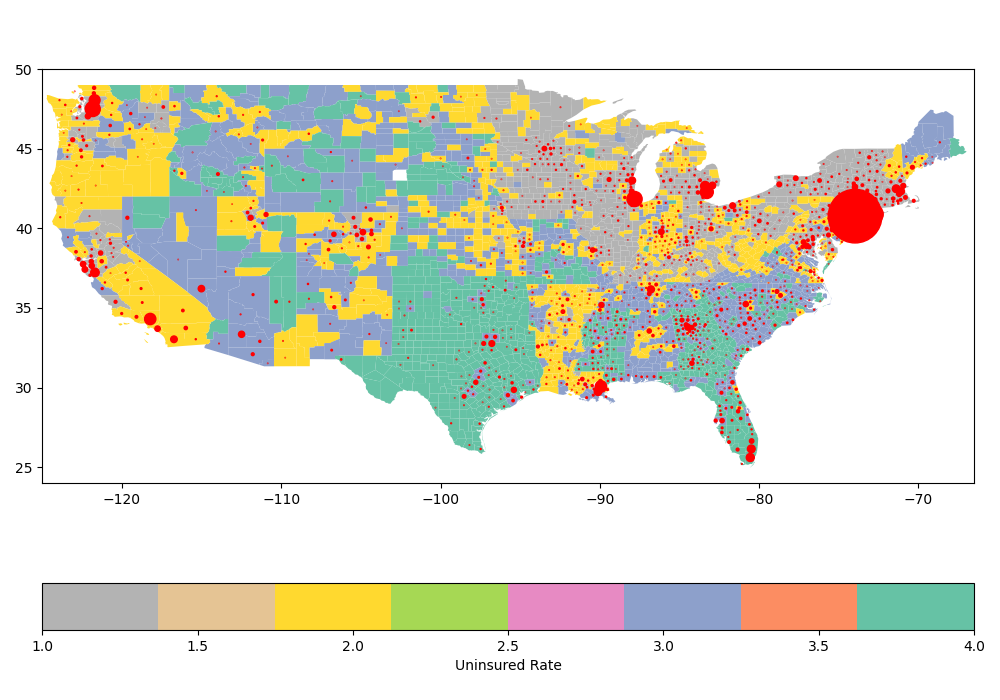

In [10]:
fig, ax = plt.subplots(figsize=(10,7))

us_all.plot(column='pct_bin',cmap='Set2_r',ax=ax, legend=True, legend_kwds={'label':"Uninsured Rate",
                       'orientation':"horizontal"})
us_gdf.plot(ax=ax, color='red', markersize=.1*us_gdf['Confirmed'])
ax.set_facecolor('white')
ax.set_xlim(-125, -66.5)
ax.set_ylim(24,50)
fig.tight_layout()